# SHAP-IQ with scikit-learn

In this example, we use the popular California housing dataset for regression available at https://www.kaggle.com/datasets/camnugent/california-housing-prices.

### Import Packages

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import shapiq

shapiq.__version__

'1.1.1.dev'

### Load Data
Let's load the California housing dataset and split it into training and test sets.

In [2]:
X, y = shapiq.load_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.25, random_state=42
)
n_features = X_train.shape[1]

### Train a Model with Scikit-learn
Here we train a random forest regressor with 500 trees.
The model achieves a relatively high R2 score on the test set.

In [3]:
model = RandomForestRegressor(
    n_estimators=500, max_depth=n_features, max_features=2 / 3, max_samples=2 / 3, random_state=42
)
model.fit(X_train, y_train)
print("Train R2: {:.4f}".format(model.score(X_train, y_train)))
print("Test  R2: {:.4f}".format(model.score(X_test, y_test)))

Train R2: 0.7991
Test  R2: 0.7462


### Model-Agnostic Explainer

We use `shapiq.TabularExplainer` to explain any machine learning model for tabular data. 

It has the following basic parameters:

- `model`: The model to be explained as a callable function expecting data points as input and returning 1-dimensional predictions.

- `data`: A background dataset to be used for imputation.

In [4]:
explainer_tabular = shapiq.TabularExplainer(model=model, data=X_train, index="SII", max_order=2)

Next, select an instance to be explained.

In [5]:
x = X_test[24]

Call an `explain()` interface setting the `budget`, i.e. the maximum number of model evaluations (coallitions).

In [6]:
interaction_values = explainer_tabular.explain(x, budget=2**n_features, random_state=0)
interaction_values

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=False, estimation_budget=256,
    n_players=8, baseline_value=2.06997805874991
)

An output is stored in the `shapiq.InteractionValues` object. Its main attribute is `dict_values` storing Shapley interaction values as a dictionary.

In [7]:
interaction_values.dict_values

{(): 0.0,
 (0,): 0.039693784765076436,
 (1,): -0.08787130505402384,
 (2,): -0.030182556659407715,
 (3,): 0.010314497962081752,
 (4,): 0.016404012689986223,
 (5,): -0.16357903857975523,
 (6,): 0.17346380234936085,
 (7,): -0.26577439369516503,
 (0, 1): -0.042585290353095114,
 (0, 2): 0.024107340036971913,
 (0, 3): -0.014564433306669166,
 (0, 4): -0.017044014029018048,
 (0, 5): -0.09701443947586665,
 (0, 6): -0.05864803944795568,
 (0, 7): 0.03137724668768478,
 (1, 2): -0.011967872732625255,
 (1, 3): -0.011074616354327904,
 (1, 4): -0.012418359902248854,
 (1, 5): 0.11602598619389336,
 (1, 6): -0.014121881491565378,
 (1, 7): -0.011773778503153455,
 (2, 3): -0.013172619834983895,
 (2, 4): -0.011354684202826508,
 (2, 5): -0.016448764531913802,
 (2, 6): -0.003504932321068288,
 (2, 7): -0.01694232037048102,
 (3, 4): -0.011503262190555282,
 (3, 5): -0.009255317162506105,
 (3, 6): -0.012895688622052844,
 (3, 7): -0.012188341974186959,
 (4, 5): -0.020107243385105573,
 (4, 6): -0.011409873190119286

One can retrieve only 2-order values with `get_n_order(2)` (object) and `get_n_order_values(2)` (values themselves).

In [8]:
interaction_values.get_n_order(2).dict_values

{(0, 1): -0.042585290353095114,
 (0, 2): 0.024107340036971913,
 (0, 3): -0.014564433306669166,
 (0, 4): -0.017044014029018048,
 (0, 5): -0.09701443947586665,
 (0, 6): -0.05864803944795568,
 (0, 7): 0.03137724668768478,
 (1, 2): -0.011967872732625255,
 (1, 3): -0.011074616354327904,
 (1, 4): -0.012418359902248854,
 (1, 5): 0.11602598619389336,
 (1, 6): -0.014121881491565378,
 (1, 7): -0.011773778503153455,
 (2, 3): -0.013172619834983895,
 (2, 4): -0.011354684202826508,
 (2, 5): -0.016448764531913802,
 (2, 6): -0.003504932321068288,
 (2, 7): -0.01694232037048102,
 (3, 4): -0.011503262190555282,
 (3, 5): -0.009255317162506105,
 (3, 6): -0.012895688622052844,
 (3, 7): -0.012188341974186959,
 (4, 5): -0.020107243385105573,
 (4, 6): -0.011409873190119286,
 (4, 7): -0.011490783339750722,
 (5, 6): -0.02718532205687375,
 (5, 7): 0.006640562391589585,
 (6, 7): -0.05674171687511046}

In [9]:
interaction_values.get_n_order_values(2)

array([[ 0.03969378, -0.04258529,  0.02410734, -0.01456443, -0.01704401,
        -0.09701444, -0.05864804,  0.03137725],
       [-0.04258529, -0.08787131, -0.01196787, -0.01107462, -0.01241836,
         0.11602599, -0.01412188, -0.01177378],
       [ 0.02410734, -0.01196787, -0.03018256, -0.01317262, -0.01135468,
        -0.01644876, -0.00350493, -0.01694232],
       [-0.01456443, -0.01107462, -0.01317262,  0.0103145 , -0.01150326,
        -0.00925532, -0.01289569, -0.01218834],
       [-0.01704401, -0.01241836, -0.01135468, -0.01150326,  0.01640401,
        -0.02010724, -0.01140987, -0.01149078],
       [-0.09701444,  0.11602599, -0.01644876, -0.00925532, -0.02010724,
        -0.16357904, -0.02718532,  0.00664056],
       [-0.05864804, -0.01412188, -0.00350493, -0.01289569, -0.01140987,
        -0.02718532,  0.1734638 , -0.05674172],
       [ 0.03137725, -0.01177378, -0.01694232, -0.01218834, -0.01149078,
         0.00664056, -0.05674172, -0.26577439]])

### Visualization of Shapley interactions

`shapiq` includes the following plotting functions:

- [network_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.network_plot)

- [stacked_bar_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.stacked_bar_plot)

- [force_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.force_plot)

- and [bar_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.bar_plot) for global feature (interaction) importance.

For details of their parameters, refer to the [API reference](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html).

(<Figure size 600x600 with 1 Axes>, <Axes: >)

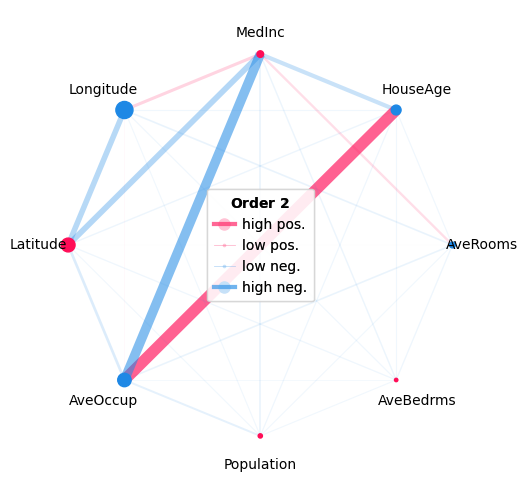

In [10]:
shapiq.network_plot(
    first_order_values=interaction_values.get_n_order_values(1),
    second_order_values=interaction_values.get_n_order_values(2),
    feature_names=X.columns,
)

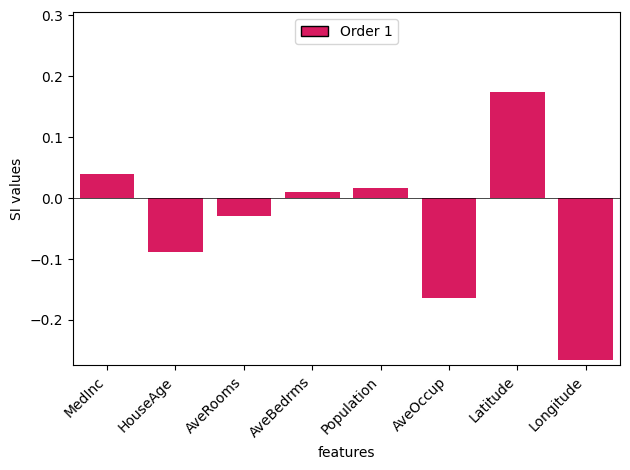

In [11]:
_ = shapiq.stacked_bar_plot(
    interaction_values.get_n_order(1),
    feature_names=X.columns,
)

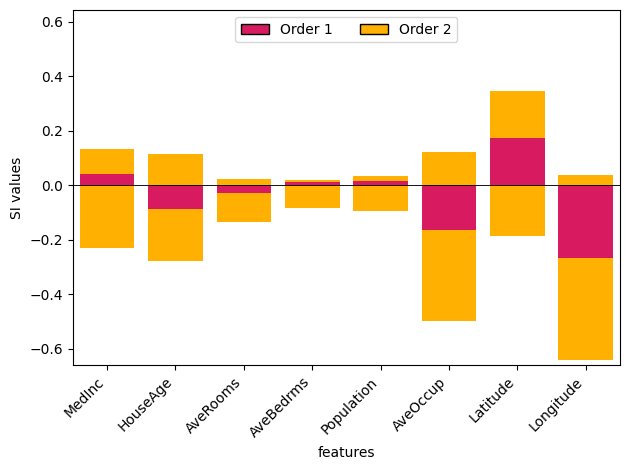

In [12]:
_ = shapiq.stacked_bar_plot(
    interaction_values=interaction_values,
    feature_names=X.columns,
)

After installing the `shap` Python package.

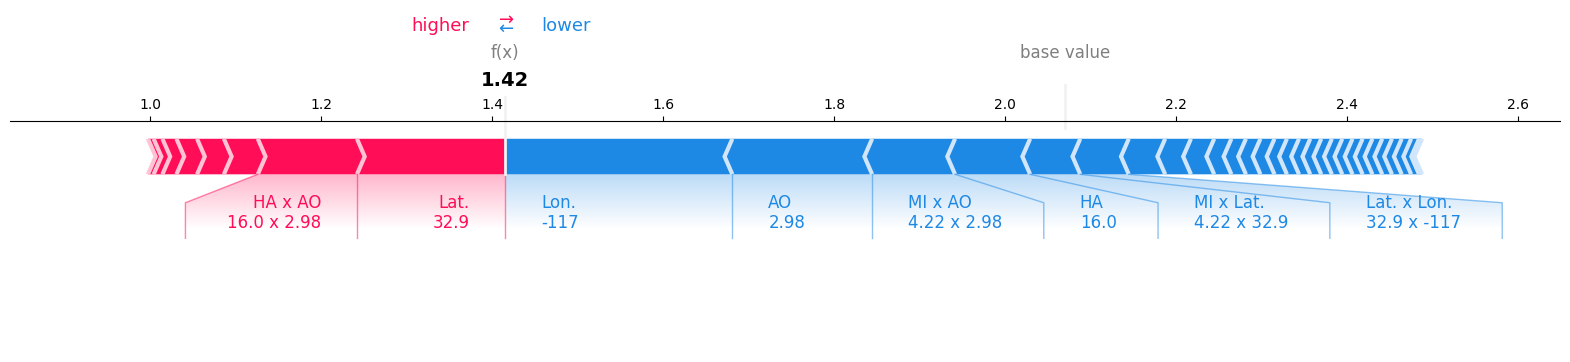

In [13]:
interaction_values.plot_force(feature_names=X.columns, feature_values=x)